# Summary of Findings


### Introduction
This dataset contains information about power outages in the US from 2000 to 2016. Each outage contains regional information like the climate region and state that each outage was in. It also has information about the causes of the outages and the extent of the damage they caused. There is also other information about the economics and power consumption of the surrounding area.

I want to create a regression model that can predict the severity of a outage so that it can be used to find areas where an outage would have large consequences. The variable that is predicted is the number of customers affected because large outages would affect more people. The model should have the lowest mean squared error in order to be as close as possible to the actual severity of the outage.

### Baseline Model
I first removed some features like outage duration and observation number because they either can't be known before an outage or they are not relevant to the outage. There were 43 features left of which 5 were nominal and 38 were quantitative. The model imputed missing data and one hot encoded the nominal columns during preprocessing.

The model used a Decision Tree Regressor in order to predict the number of customers affected. The RMSE for the test data was about 408,311 which looks high but the number of customers affected can also be on the order of millions. This error can be reduced with a better model.

### Final Model
The improved model has features of price of electricity and amount of electricity sold standardized to region of the country. These are good for the data because different regions usually have different electricity needs and standardizing checks if an amount is large in relation to its area.

In order to find the best model, I tested out a Decision trees, K Nearest Neighbors, Logistic, and Linear regression. For decision trees and KNN, I used GridSearchCV in order to find the best hyperparameters like max depth or number of neighbors. I then tested each model to get the RMSE of each and found that Linear Regression was the best with about 378950. I trained a linear model on the whole dataset as my final model.

### Fairness Evaluation
I wanted to see if the model was equally as fair for smaller and larger states so I split up the data by population. I used mean square error as the parity measure because I was measuring the difference between quantitative amounts. The hypotheses are:<br>

Null Hypothesis: The model is fair; the mse for small and large states are roughly the same <br>
Alternative Hypothesis: The model is unfair; the mse for the subsets are different <br>

I first found the observed differences between predictions and actual amounts for small and large states. Then I permuted the values 10,000 times and compared it to the observed value to get a p value of 0. This is smaller than a regular alpha of 0.05 so I rejected the null hypothesis. The model is unfair when comparing small and large states.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

### Baseline Model

This cell reads in the dataset of power outages with the correct rows and labels from the excel file.

In [3]:
outages = pd.read_excel('outage.xlsx', header=5, skiprows = lambda x: x==6, usecols = lambda x: x!='variables')
outages.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


First we have to clean the data. There are some outages where the number of customers affected is missing which makes the data useless. This column only keeps rows that have the number of customers affected.

In [4]:
missing_data = outages['CUSTOMERS.AFFECTED'].isna()
data = outages[~missing_data].reset_index(drop=True)
data.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,6,2010,11.0,Minnesota,MN,MRO,East North Central,-1.4,cold,2010-11-13,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


This cell contains a list of features that would be unknown before an outage such as outage duration. It also has features that are useless like the observation number of the outage.

In [5]:
unknown_features = ['OBS','YEAR','MONTH','U.S._STATE',
                    'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
                    'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY.DETAIL',
                    'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW']

This class is created as a transformer to drop columns within the pipeline.

In [6]:
class DropFeatures():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return pd.DataFrame(X).drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

This cell separates all the numerical columns from categorical columns because the categorical ones have to be one hot encoded before being used.

In [7]:
X = data.drop(columns=['CUSTOMERS.AFFECTED'])
y = data['CUSTOMERS.AFFECTED']
numerical = X.select_dtypes(include='number').columns.to_list()
categorical = X.select_dtypes(include='object').columns.to_list()
num_cols = np.setdiff1d(numerical, unknown_features)
cat_cols = np.setdiff1d(categorical, unknown_features)

This cell creates a starting pipeline to create a model. The imputer column transformer imputes missing data in the columns using the mean for quantitative columns and mode for categorical ones. It then one hot encodes the categorical columns. Then it uses linear regression to predict the number of customers affected.

In [8]:
imputer = ColumnTransformer(
    transformers=[
        ('numerical', SimpleImputer(strategy='mean'), num_cols),
        ('categorical', SimpleImputer(strategy='most_frequent'), cat_cols),
        ('one-hot', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough')

one_hot = ColumnTransformer(
    transformers=[
        ('one-hot', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough')

baseline = Pipeline([
    ('drop-unknown', DropFeatures(columns=unknown_features)),
    ('imputer', imputer),
    ('drop-categorical', DropFeatures(columns=[38,39,40,41,42])),
    ('regression', DecisionTreeRegressor())
])

This function calculates root mean squared error which is the statistic used to measure the error of the model.

In [9]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

This cell fits the model to training data and then makes a prediction based on test data. It then finds the RMSE to be about 408311.

In [529]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
base_model = baseline.fit(X_train, y_train)
pred = base_model.predict(X_test)
rmse(pred, y_test)

408311.37139552715

### Final Model

This class is a transformer that scales a numerical feature by a categorical one inside the pipeline.

In [10]:
class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass 

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        self.grps_ = df.groupby(df.columns[0]).agg(['mean', 'std']).T
        return self

    def transform(self, X, y=None):
        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        
        df = pd.DataFrame(X)
        for val in df[df.columns[0]].unique():
            mask = df[df.columns[0]] == val
            for col in df.columns[1:]:
                df.loc[mask, col] = (df.loc[mask, col] - self.grps_[val].to_dict()[col, 'mean']) / self.grps_[val].to_dict()[col, 'std']
        
        
        return df[df.columns[1:]]

This pipeline creates 2 new features which are the price of electricity and total electricity sale scaled within the category of climate region. This pipeline also imputes missing data and one hot encodes the categorical columns. It still uses the decision tree regressor for now.

In [11]:
imputer = ColumnTransformer(
    transformers=[
        ('numerical', SimpleImputer(strategy='mean'), num_cols),
        ('categorical', SimpleImputer(strategy='most_frequent'), cat_cols),
    ],
    remainder='drop')

scaler = ColumnTransformer(
    transformers=[
        ('price', StdScalerByGroup(), [40,33]),
        ('sales', StdScalerByGroup(), [40,36]),
        ('region', FunctionTransformer(lambda x: x), [40])
    ],
    remainder='passthrough')

encode = ColumnTransformer(
    transformers=[
        ('one-hot', OneHotEncoder(), [2,39,40,41,42])
    ],
    remainder='passthrough')

preproc = Pipeline([
    ('drop-unknown', DropFeatures(columns=unknown_features)),
    ('imputer', imputer),
    ('scale', scaler),
    ('encode', encode)
])

final = Pipeline([
    ('preproc', preproc),
    ('regression', DecisionTreeRegressor())
])

This model gives an RMSE of about 397115 which can be improved with different models or parameters.

In [429]:
final_model = final.fit(X_train, y_train)
final_pred = final_model.predict(X_test)
rmse(final_pred, y_test)

397115.3950719488

This cell tries out many hyperparameters for a decision tree regressor and finds the best ones.

In [530]:
hyperparameters = {
    'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None], 
    'min_samples_split': [2, 3, 5, 7, 10, 15, 20],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
searcher = GridSearchCV(DecisionTreeRegressor(), hyperparameters, cv=5)
searcher.fit(final_model['preproc'].transform(X_train), y_train)
searcher.best_params_

{'criterion': 'squared_error', 'max_depth': 2, 'min_samples_split': 2}

This cell finds the RMSE using those parameters to get about 389882.

In [531]:
pl = Pipeline([
    ('preproc', preproc),
    ('regression', DecisionTreeRegressor(criterion='squared_error', max_depth=2, min_samples_split=2))
])
model = pl.fit(X_train, y_train)
model_pred = model.predict(X_test)
rmse(model_pred, y_test)

389882.9465073559

This cell tries out many hyperparameters for a K nearest neighbors regressor and finds the best ones.

In [532]:
hyperparameters = {
    'n_neighbors': [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
}
searcher = GridSearchCV(KNeighborsRegressor(), hyperparameters, cv=5)
searcher.fit(final_model['preproc'].transform(X_train), y_train)
searcher.best_params_

{'leaf_size': 1, 'n_neighbors': 50}

This cell finds the RMSE using those parameters to get about 391532.

In [534]:
pl = Pipeline([
    ('preproc', preproc),
    ('regression', KNeighborsRegressor(leaf_size=1, n_neighbors=50))
])
model = pl.fit(X_train, y_train)
model_pred = model.predict(X_test)
rmse(model_pred, y_test)

391532.20530170377

This cell finds the RMSE when using a logistic regression model which is 438641.

In [535]:
pl = Pipeline([
    ('preproc', preproc),
    ('regression', LogisticRegression())
])
model = pl.fit(X_train, y_train)
model_pred = model.predict(X_test)
rmse(model_pred, y_test)

C:\Users\rebal\.conda\envs\dsc80\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


438641.44887565775

This cell finds the RMSE when using a linear model to be about 378950.

In [536]:
pl = Pipeline([
    ('preproc', preproc),
    ('regression', LinearRegression())
])
model = pl.fit(X_train, y_train)
model_pred = model.predict(X_test)
rmse(model_pred, y_test)

378950.8665046697

From this analysis, the model with the lowest error is the linear model which is shown below.

In [12]:
pl = Pipeline([
    ('preproc', preproc),
    ('regression', LinearRegression())
])
final_model = pl.fit(X, y)

### Fairness Evaluation

We want to check if the predicted number of people affected is fair for states with small and large populations. This cell finds large states which have over the median number of people which is about 10,000,000 people and small states which are the rest.

In [13]:
size_threshold = (data['POPULATION'] >= data['POPULATION'].median())
large = data[size_threshold]
small = data[~size_threshold]

This cell predicts the number of customers affected separately for small and large populations.

In [14]:
large_X = large.drop(columns=['CUSTOMERS.AFFECTED'])
large_y = large['CUSTOMERS.AFFECTED']
small_X = small.drop(columns=['CUSTOMERS.AFFECTED'])
small_y = small['CUSTOMERS.AFFECTED']
large_pred = final_model.predict(large_X)
small_pred = final_model.predict(small_X)

This cell creates a dataframe with the squared error for each prediction and the size of the population.

In [15]:
large_errors = pd.DataFrame({'Error':(large_pred - large_y) ** 2, 'Type':'Large'})
small_errors = pd.DataFrame({'Error':(small_pred - small_y) ** 2, 'Type':'Small'})
errors = pd.concat([large_errors, small_errors]).reset_index(drop=True)
errors.head()

,Error,Type
0,1.186391e+08,Large
1,2.981330e+10,Large
2,1.063005e+08,Large
3,3.192411e+08,Large
4,4.186018e+09,Large


Now we have to run a permutation test to see if the difference errors between small and large populations are only due to chance. The hypotheses are <br>
Null Hypothesis: The model is fair; the mse for small and large states are roughly the same <br>
Alternative Hypothesis: The model is unfair; the mse for the subsets are different <br>
First we get the observed test statistic which is difference in means.

In [20]:
def test_statistic(df):
    return df.groupby('Type').mean().diff().iloc[1,0]

observed = test_statistic(errors)
observed

-104836496803.96036

This cell shuffles the type column 10000 times and finds the test statistic each time.

In [25]:
test_stats = []
for i in range(10000):
    shuffled = errors.assign(Type=np.random.permutation(errors['Type']))
    test_stats.append(test_statistic(shuffled))

This plot shows the distribution of simulated test statistics which are not as extreme as the observed one.

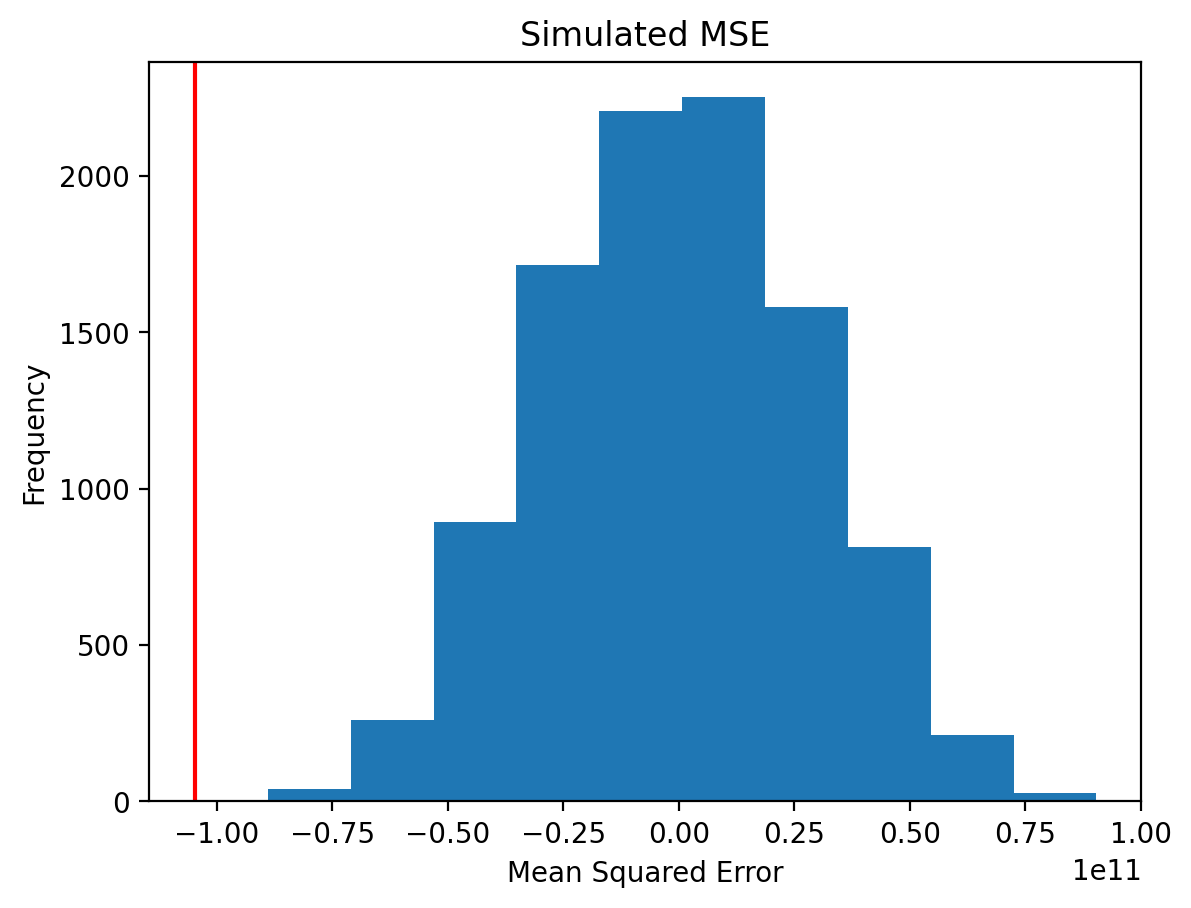

In [ ]:
plt.hist(test_stats)
plt.title('Simulated MSE')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.axvline(observed, color='red')
plt.show()

This cell finds the p-value which is 0. We reject the null hypothesis and say that MSE is different for large and small states.

In [27]:
np.mean(observed >= test_stats)

0.0